In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import matplotlib as mpl

mpl.style.use("seaborn")

/home/jcartus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
molecules = np.load("../data/400/molecules400.npy")
S = np.load("../data/400/S400.npy")
P = np.load("../data/400/P400.npy")

dim = 26

In [3]:
from SCFInitialGuess.utilities.dataset import make_butadien_dataset

folder = "../data/400/"

dataset, molecules = make_butadien_dataset(
    np.load(folder + "molecules400.npy"),
    np.load(folder + "S400.npy"),
    np.load(folder + "P400.npy"),
    test_samples=100
)


[-] 2018-09-07 13:29:15: Data set normalized. Mean value std: 0.050517110993838175


# Find Orientation and Create Rotation Matrix 

In [4]:

mol = molecules[0][0]

C, H = [], []

for x in mol.geometry:
    if x[0] == "C":
        C.append(x[1])
    elif x[0] == "H":
        H.append(x[1])
C = np.array(C)
H = np.array(H)

mol.positions, mol.geometry, mol.positions[3], mol.positions[0]

([[-2.159248, 0.859042, 0.608493],
  [-1.336932, 0.02525, 0.032877],
  [0.167858, 0.168271, 0.291008],
  [1.111976, -0.761527, -0.171297],
  [-3.201248, 0.998443, 0.535132],
  [-1.811307, 1.573487, 1.26986],
  [-1.75254, -0.879533, -0.428175],
  [0.486904, 1.111026, 0.86175],
  [0.824793, -1.641503, -0.631406],
  [2.222957, -0.593778, -0.009088]],
 [('C', [-2.159248, 0.859042, 0.608493]),
  ('C', [-1.336932, 0.02525, 0.032877]),
  ('C', [0.167858, 0.168271, 0.291008]),
  ('C', [1.111976, -0.761527, -0.171297]),
  ('H', [-3.201248, 0.998443, 0.535132]),
  ('H', [-1.811307, 1.573487, 1.26986]),
  ('H', [-1.75254, -0.879533, -0.428175]),
  ('H', [0.486904, 1.111026, 0.86175]),
  ('H', [0.824793, -1.641503, -0.631406]),
  ('H', [2.222957, -0.593778, -0.009088])],
 [1.111976, -0.761527, -0.171297],
 [-2.159248, 0.859042, 0.608493])

In [6]:
def butadien_direction(mol):
    """Vector from 1st C atom to the 4th."""
    return np.array(mol.positions[3]) - np.array(mol.positions[0])
butadien_direction(mol)

array([ 3.271224, -1.620569, -0.77979 ])

In [20]:
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

def plot_butadiene(mol, fig, ax):
    
    C, H = [], []
    
    for x in mol.geometry:
        if x[0] == "C":
            C.append(x[1])
        elif x[0] == "H":
            H.append(x[1])
    C = np.array(C)
    H = np.array(H)
    
    direction = np.array([C[0], C[0] + butadien_direction(mol)])
    

 

    ax.plot(C[:,0], C[:,1], C[:,2], marker="o")
    ax.scatter(H[:,0], H[:,1], H[:,2], marker="x")
    #ax.plot([C[0, 0], direction[0]], [C[0, 1], direction[1]], [C[0, 2], direction[2]])
    ax.plot(direction[:,0], direction[:,1], direction[:,2])

## Original 

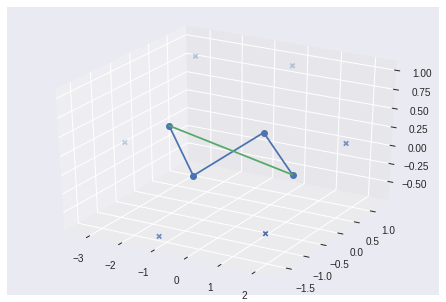

In [21]:
%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)
plot_butadiene(mol, fig, ax)
plt.show()


## Rotatate Molecule

In [9]:
from SCFInitialGuess.utilities.dataset import Molecule

class RotatingMolecule(Molecule):
    
    def rotate(self, R):
        #self.positions = np.matmul(self.positions, R.T)
        rotate_molecule(self, R)

def rotate_molecule(mol, R):
    #mol.positions = np.array([np.dot(v, R) for v in mol.positions])
    mol.positions = np.matmul(mol.positions, R.T)
    
R = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    

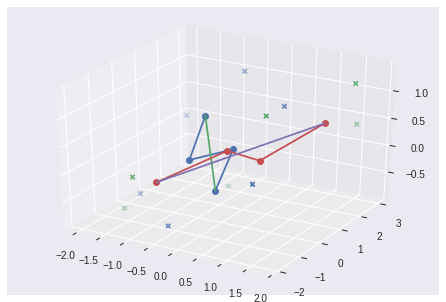

In [22]:
mol_rotated = rotate_molecule(mol, R)
%matplotlib inline

mol_rotated = RotatingMolecule(mol.species, mol.positions)
mol_rotated.rotate(R)

fig = plt.figure()
ax = Axes3D(fig)
plot_butadiene(mol, fig, ax)
plot_butadiene(mol_rotated, fig, ax)
plt.show()

## Find the Right Rotation

In [11]:
def find_rotation(u, v):
    """find roation R, so that u R.T = v"""
    
    # find rotation axis
    n = np.cross(u, v)
    norm = np.linalg.norm(n)
    
    n0 = n / norm
    
    # find angle
    phi = np.arcsin(norm / (np.linalg.norm(u) * np.linalg.norm(v)))
    
    return n0, phi


x = np.array([1, 0, 0])
y = np.array([0, 1, 0])

find_rotation(x, y)

(array([0., 0., 1.]), 1.5707963267948966)

In [12]:
def rotation_matrix(n, phi):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    
    http://mathworld.wolfram.com/EulerParameters.html
    """
    
    e = []
    e += [np.cos(phi / 2)]
    e += list(n * np.sin(phi / 2) / np.linalg.norm(n))
    
    R = np.array([
        [
            e[0]**2 + e[1]**2 - e[2]**2 - e[3]**2,
            2 * (e[1] * e[2] + e[0] * e[3]),
            2 * (e[1] * e[3] - e[0] * e[2])
        ],
        [
            2 * (e[1] * e[2] - e[0] * e[3]),
            e[0]**2 - e[1]**2 + e[2]**2 - e[3]**2,
            2 * (e[2] * e[3] - e[0] * e[1]),
        ],
        [
            2 * (e[1] * e[3] - e[0] * e[1]),
            2 * (e[2] * e[3] - e[0] * e[1]),
            e[0]**2 - e[1]**2 - e[2]**2 + e[3]**2,
        ]
        
    ])
    
    return R

R = rotation_matrix(np.array([0, 0, 1]), np.pi / 2 )

[ 3.73545687e+00  2.77555756e-16 -1.48607783e-01]


<IPython.core.display.Javascript object>


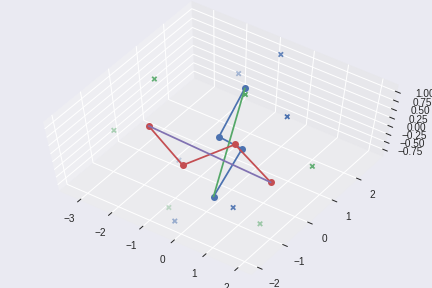

In [29]:
direction_old = butadien_direction(mol)
n, phi = find_rotation(direction_old, np.array([1, 0, 0]))
R = rotation_matrix(n , -phi)

mol_rotated = RotatingMolecule(mol.species, mol.positions)
mol_rotated.rotate(R)
print(butadien_direction(mol_rotated))

%matplotlib notebook
fig = plt.figure()
ax = Axes3D(fig)
plot_butadiene(mol, fig, ax)
plot_butadiene(mol_rotated, fig, ax)
plt.show()